In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

In [10]:
customers = pd.read_csv('/content/zeotap_Customers.csv')
products = pd.read_csv('/content/zeotap_Products.csv')
transactions = pd.read_csv('/content/zeotap_Transactions.csv')

In [11]:
agg_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count']
})
agg_transactions.columns = ['total_spend', 'avg_spend', 'transaction_count']
agg_transactions.reset_index(inplace=True)

customer_data = pd.merge(customers, agg_transactions, on='CustomerID', how='inner')

customer_data = customer_data.drop(['CustomerID'], axis=1)

customer_data.fillna(0, inplace=True)

In [12]:
from sklearn.preprocessing import StandardScaler

numeric_columns = customer_data.select_dtypes(include=["number"]).columns
non_numeric_columns = customer_data.select_dtypes(exclude=["number"]).columns

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(customer_data[numeric_columns])

scaled_numeric_df = pd.DataFrame(scaled_numeric_data, columns=numeric_columns, index=customer_data.index)

final_data = pd.concat([customer_data[non_numeric_columns], scaled_numeric_df], axis=1)

final_data.head()

,CustomerName,Region,SignupDate,total_spend,avg_spend,transaction_count
0,Lawrence Carroll,South America,2022-07-10,-0.061701,-0.070263,-0.011458
1,Elizabeth Lutz,Asia,2022-02-13,-0.877744,-0.934933,-0.467494
2,Michael Rivera,South America,2024-03-07,-0.405857,-0.026271,-0.467494
3,Kathleen Rodriguez,South America,2022-10-09,1.032547,-0.076769,1.356650
4,Laura Weber,Asia,2022-08-15,-0.783929,-0.040028,-0.923530


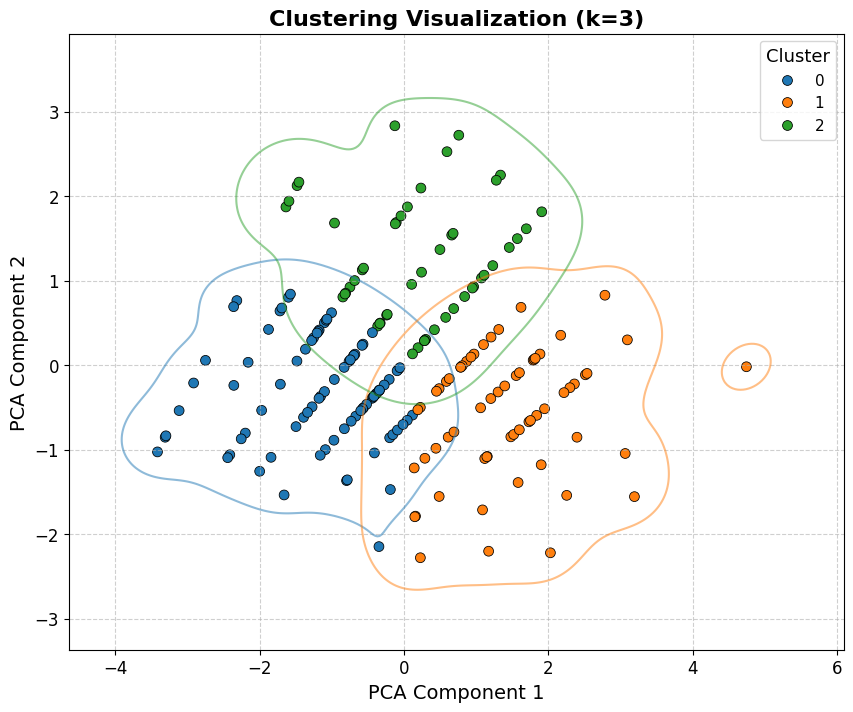

   k  DB Index  Silhouette Score
0  3  0.957821          0.360273


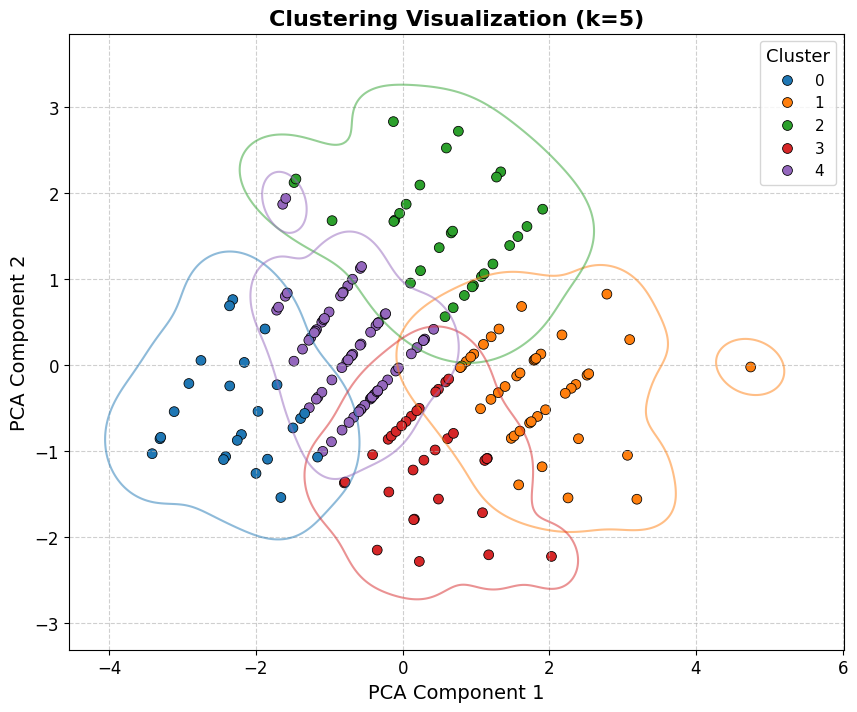

   k  DB Index  Silhouette Score
0  3  0.957821          0.360273
1  5  0.894316          0.341908


In [16]:
clusters = [3,5]
results = []

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=11)
    labels = kmeans.fit_predict(scaled_numeric_data)
    db_index = davies_bouldin_score(scaled_numeric_data, labels)
    sil_score = silhouette_score(scaled_numeric_data, labels)
    results.append({'k': k, 'DB Index': db_index, 'Silhouette Score': sil_score})

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_numeric_data)
    plt.figure(figsize=(10, 8))

    sns.scatterplot(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        hue=labels,
        palette='tab10',
        s=50,
        edgecolor='black'
    )

    for cluster_label in np.unique(labels):
        cluster_points = reduced_data[labels == cluster_label]
        sns.kdeplot(
            x=cluster_points[:, 0],
            y=cluster_points[:, 1],
            levels=1,
            linewidths=1.5,
            color=sns.color_palette('tab10')[cluster_label],
            alpha=0.5
        )

    plt.title(f'Clustering Visualization (k={k})', fontsize=16, weight='bold')
    plt.xlabel('PCA Component 1', fontsize=14)
    plt.ylabel('PCA Component 2', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Cluster', title_fontsize=13, fontsize=11, loc='best')
    plt.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

    results_df = pd.DataFrame(results)
    print(results_df)